In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.pyplot as plt
import torch as nn
from sklearn.model_selection import train_test_split
from torch.nn import Dropout , Linear 
import numpy as np # linear algebra
import pandas as pd

In [3]:
TRAIN = 'Jigsaw Toxicity/train.csv'
TEST = 'Jigsaw Toxicity/test.csv'
TEST_LABEL = 'Jigsaw Toxicity/test_labels.csv'
SAMPLE = 'Jigsaw Toxicity/sample_submission.csv'
EPOCHS = 2

In [4]:
train_csv = pd.read_csv(TRAIN)
test_csv = pd.read_csv(TEST)
test_label = pd.read_csv(TEST_LABEL)
sample_sub = pd.read_csv(SAMPLE)

In [5]:
train_csv.describe()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train_csv.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
import re
def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text) #remove mentions or usernames in the text.
    text = re.sub(r'[0-9]+' , '' ,text) # removes any sequence of digits

    text = re.sub(r'\s([@][\w_-]+)', '', text).strip() 
    text = re.sub(r'&amp;', '&', text) #replaces the HTML entity '&' with an ampersand '&'
    text = re.sub(r'\s+', ' ', text).strip() #extra whitespace
    text = text.replace("#" , " ")
    encoded_string = text.encode("ascii", "ignore") #encodes the text into ASCII format
    decode_string = encoded_string.decode() #decodes the ASCII-encoded text back into a string.
    return decode_string

In [14]:
print('Original : ' ,test_csv['comment_text'][1])
print('Processed :' , text_preprocessing(test_csv['comment_text'][1]))

Original :  == From RfC == 

 The title is fine as it is, IMO.
Processed : == From RfC == The title is fine as it is, IMO.


In [15]:
X_toxic = train_csv[train_csv['toxic'] == 1]['comment_text'].values
X_non_toxic = train_csv[train_csv['toxic'] == 0]['comment_text'].sample(15294).values

Y_toxic = train_csv[train_csv['toxic'] == 1]['toxic'].values
Y_non_toxic = train_csv[train_csv['toxic'] == 0]['toxic'].sample(15294).values

X = np.concatenate([X_toxic, X_non_toxic])
Y = np.concatenate([Y_toxic, Y_non_toxic])

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=2021)

In [16]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080


In [17]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            truncation = True,
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [18]:
MAX_LEN = 300

token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Token IDs:  [101, 10338, 6342, 9102, 2077, 2017, 18138, 2105, 2006, 2026, 2147, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [20]:
%time
import torch
import torch.nn as nn
from transformers import DistilBertModel

# Create the BertClassfier class
class DistilBertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(DistilBertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        # self.LSTM = nn.LSTM(D_in,D_in,bidirectional=True)
        # self.clf = nn.Linear(D_in*2,2)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            # nn.LSTM(D_in,D_in)
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    distilbert_classifier = DistilBertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    distilbert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(distilbert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return distilbert_classifier, optimizer, scheduler

In [23]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [24]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [25]:
set_seed(42)    # Set seed for reproducibility
distilbert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(distilbert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.427060   |     -      |     -     |   6.67   
   1    |   40    |   0.248961   |     -      |     -     |   4.15   
   1    |   60    |   0.229559   |     -      |     -     |   4.15   
   1    |   80    |   0.169606   |     -      |     -     |   4.34   
   1    |   100   |   0.187114   |     -      |     -     |   4.38   
   1    |   120   |   0.246449   |     -      |     -     |   4.29   
   1    |   140   |   0.208580   |     -      |     -     |   4.16   
   1    |   160   |   0.201878   |     -      |     -     |   4.16   
   1    |   180   |   0.233902   |     -      |     -     |   4.17   
   1    |   200   |   0.159040   |     -      |     -     |   4.18   
   1    |   220   |   0.162073   |     -      |     -     |   4.18   
   1    |   240   |   0.186623   |     -      |     -     |   4.18   


In [26]:
import torch.nn.functional as F


In [27]:
def distilbert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [28]:
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score

def evaluate_roc(probs, y_true):
    """
    - Print AUC, accuracy, precision, recall, and F-measure on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Get precision, recall, and F-measure
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F-measure: {f_measure:.4f}')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9874
Accuracy: 94.77%
Precision: 0.9372
Recall: 0.9583
F-measure: 0.9476


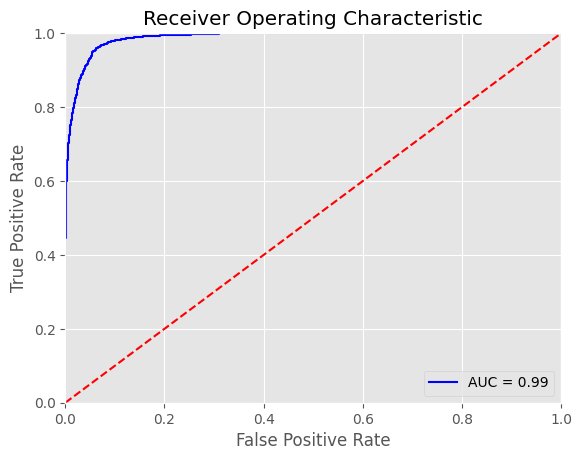

In [29]:
probs = distilbert_predict(distilbert_classifier, val_dataloader)
evaluate_roc(probs, y_val)

In [30]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BertConfig
config = BertConfig(
    vocab_size=102025, 
    hidden_size=192,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=1024,
    max_position_embeddings=512,
    type_vocab_size=2,
    layer_norm_eps=1e-12,
    gradient_checkpointing=True,
    initializer_range=0.02
)

student_model = BertForSequenceClassification(config=config)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\configuration_utils.py:387: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [108]:
temperature = 10

def dist_loss(s, t, label):
    s_logits = s.logits

    # Convert labels to one-hot encoding
    # label_one_hot = F.one_hot(label, num_classes=num_classes).float()

    # Compute the log probabilities and distillation loss for hard targets
    # log_prob_s1 = F.log_softmax(s_logits, dim=1)
    # dist_loss1 = -(label_one_hot * log_prob_s1).sum(dim=1).mean()
    dist_loss1 = nn.CrossEntropyLoss(s, label)
    # Compute the probabilities and log probabilities for soft targets
    prob_t = F.softmax(t.logits / temperature, dim=1)
    log_prob_s2 = F.log_softmax(s_logits / temperature, dim=1)

    # Compute the distillation loss for soft targets
    dist_loss2 = -(prob_t * log_prob_s2).sum(dim=1).mean()

    # Combine the losses
    loss = dist_loss1 + dist_loss2

    return loss

# def dist_loss(s, t, label):

#     s = s.logits
    
#     label = F.one_hot(label, num_classes=6)
#     log_prob_s1 = F.log_softmax(s, dim=1)
#     dist_loss1 = -(label*log_prob_s1).sum(dim=2).mean()
    
#     prob_t = F.softmax(t/temperature, dim=1)
#     log_prob_s2 = F.log_softmax(s/temperature, dim=1) 
#     # print(prob_t.size()) 
#     # print(log_prob_s2.size()) 
#     dist_loss2 = -(prob_t*log_prob_s2).sum(dim=2).mean()
   
#     loss = dist_loss1 + dist_loss2
#     # print(type(loss))
#     # print(loss.size())
#     return loss

In [109]:
def distilled_evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask).logits

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [110]:

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
def distillation_train(student_model, train_dataloader, val_dataloader=None, epochs=2, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        student_model.to("cuda")
        # Put the model into the training mode
        student_model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = distilbert_classifier(b_input_ids, b_attn_mask)
            # Perform a forward pass. This will return logits.
            
            logits = student_model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            
            # loss = loss_fn(logits, b_labels)
            loss = dist_loss(logits, teacher_outputs, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = distilled_evaluate(student_model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [111]:
distillation_train(student_model, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


RuntimeError: Boolean value of Tensor with more than one value is ambiguous